# Cálculo de las Anomalias
Autor: Alejandro Pareja Rodríguez
- Basado en el script de Álvaro Salazar

## Paso 1: Importar librerias necesarias
* earthengine-api: Es una librería para Python y para Javascript cuya función es conectarse a los servidores de Earth Engine
* Pandas: Librería para manejo de dataframe
* Geopandas: Librería basada en pandas para manejo de archivos vectoriales
* Matplotlib y Seaborn: Librería para el desarrollo de Gráficas
* Json: Permite codificar y decodificar datos en formato JSON para intercambiar información estructurada entre sistemas


In [44]:
import ee 
import pandas as pd 
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
try:
    ee.Initialize()
except:
    ee.Authenticate(auth_mode="notebook")
    ee.Initialize()

## Paso 2: Crear variables principales y llamar a la Colección de MODIS para Temperatura Superficial Terrestre

In [45]:
startYear = 2001
endYear = 2023
LST = ee.ImageCollection('MODIS/061/MOD11A1').select('LST_Day_1km')

## Paso 3: Se Requiere de el cálculo del número de meses para generar una secuencia de meses desde el año inicial (startYear) hasta el año final (endYear), eso puedes hacerlo desde Local o desde Server

### Desde máquina Local

In [46]:
numberofMonths = (endYear-startYear+1)*12
month = ee.List.sequence(0, numberofMonths-1)

### Desde máquina Server

In [47]:
numberOfMonths2 = ee.Date.fromYMD(endYear+1, 1, 1).difference(ee.Date.fromYMD(startYear, 1, 1), "months")
month2 = ee.List.sequence(0, numberOfMonths2.int())

In [48]:
print(f"La variable numberOfMonths2 es igual a {numberOfMonths2.getInfo()}, lo cual no sirve para hacer una secuencia ya que necesitamos un número entero.\
\nPor lo tanto, se puede usar el método int(), cuyo resultado es el inmediato inferior, siendo en este caso igual a {numberOfMonths2.int().getInfo()}.\
\nEn caso de que se quiera el resultado como el inmediato superior, se usa el método ceil(), cuyo resultado es {numberOfMonths2.ceil().getInfo()}.\
\nPor último, si quieres redondearlo, el método round() da como resultado {numberOfMonths2.round().getInfo()}.")

La variable numberOfMonths2 es igual a 275.98102630444157, lo cual no sirve para hacer una secuencia ya que necesitamos un número entero.
Por lo tanto, se puede usar el método int(), cuyo resultado es el inmediato inferior, siendo en este caso igual a 275.
En caso de que se quiera el resultado como el inmediato superior, se usa el método ceil(), cuyo resultado es 276.
Por último, si quieres redondearlo, el método round() da como resultado 276.


## Paso 4: La Colección de imagenes requiere de un pre-procesamiento
* En el [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1) de MODIS se especifica un valor de __scale__ que representa la pendiente de una curva y también existe una columna __offset__ que en caso de que exista es la intersección a la curva por lo tanto se realiza la siguiente operación:
$$ \text{Imagen}_{preprocesado} = \text{offset} + \text{scale} \cdot \text{Imagen}_{inicial} $$
* En este caso solo se tiene un valor en __scale__ por lo tanto el LST inicial sera multiplicado por 0.02 según las especificaciones del [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1)
* por último se resta por el factor de 273.15 para convertir de grados Kelvin a grados Celsius

In [49]:
def Preprocess (img):
    return img.multiply(0.02).add(0).subtract(273.15).copyProperties(img,['system:time_start','system:time_end'])

modLSTday = LST.map(Preprocess)

## Paso 5: Cálculo de la medía mensual Temperatura Superficial Terrestre

In [50]:
def monthlyCalc(m):
  start = ee.Date.fromYMD(startYear,1,1).advance(m, "month") 
  end = start.advance(1, "month")
  monthy = modLSTday.filterDate(start, end)
  return monthy.mean()\
              .set('system:time_start', start.millis())\
              .set('system:time_end', end.millis())\
              .set('system:index', start.format('yyyy_MM'))
monthly = ee.ImageCollection(month2.map(monthlyCalc))


### Podemos imprimir la cantidad de imagenes que han sido creadas en la colección de imagenes

In [51]:
print(monthly.size().getInfo())

276


### También los índices de cada imagen creada, entre otras cosas

In [52]:
print(monthly.aggregate_array("system:index").getInfo())

['2001_01', '2001_02', '2001_03', '2001_04', '2001_05', '2001_06', '2001_07', '2001_08', '2001_09', '2001_10', '2001_11', '2001_12', '2002_01', '2002_02', '2002_03', '2002_04', '2002_05', '2002_06', '2002_07', '2002_08', '2002_09', '2002_10', '2002_11', '2002_12', '2003_01', '2003_02', '2003_03', '2003_04', '2003_05', '2003_06', '2003_07', '2003_08', '2003_09', '2003_10', '2003_11', '2003_12', '2004_01', '2004_02', '2004_03', '2004_04', '2004_05', '2004_06', '2004_07', '2004_08', '2004_09', '2004_10', '2004_11', '2004_12', '2005_01', '2005_02', '2005_03', '2005_04', '2005_05', '2005_06', '2005_07', '2005_08', '2005_09', '2005_10', '2005_11', '2005_12', '2006_01', '2006_02', '2006_03', '2006_04', '2006_05', '2006_06', '2006_07', '2006_08', '2006_09', '2006_10', '2006_11', '2006_12', '2007_01', '2007_02', '2007_03', '2007_04', '2007_05', '2007_06', '2007_07', '2007_08', '2007_09', '2007_10', '2007_11', '2007_12', '2008_01', '2008_02', '2008_03', '2008_04', '2008_05', '2008_06', '2008_07'

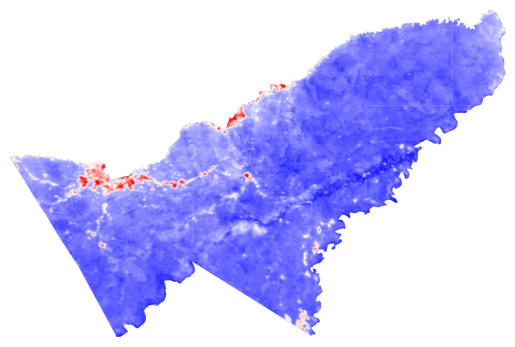

In [53]:
from matplotlib import colors, colormaps
import numpy as np
import requests
from io import BytesIO
region = ee.FeatureCollection("users/aleapr/municipios").filter(ee.Filter.eq("DEPARTAMEN", "Pando"))
first = monthly.filter(ee.Filter.eq("system:index", "2021_08")).first()
n=100
tipo = "bwr"
cmap = colormaps[tipo]
vals = np.linspace(0, 1, n)
palette = list(map(lambda x: colors.rgb2hex(cmap(x)), vals))
url = first.clip(region).getThumbURL({'format':'png', 'crs':'EPSG:4326', 'dimensions':1000, 'region':region.geometry(), "max":35, "min": 25, "palette": palette})
response = requests.get(url)
img = BytesIO(response.content)
img_array = plt.imread(img, format='png')
plt.imshow(img_array)
plt.axis('off') 
plt.show()

## Paso 6: Cálculo de la media anual de Temperatura Superficial Terrestre

### Ejercicio resolver Cálculo de la media Anual de Temperatura Superficial terrestre usando la collección de imagenes monthly creada en el paso 5

In [54]:
def yearlyCalc(y):
  start = ee.Date.fromYMD(startYear,1,1).advance(y, "year")
  end = start.advance(1, "year")
  yeary = monthly.filterDate(start, end)
  return yeary.mean()\
        .set('system:time_start', start.millis())\
        .set('system:time_end', end.millis())\
        .set('system:index', start.format('yyyy'))
                    
                      
year = ee.List.sequence(0, endYear-startYear);                      
yearly = ee.ImageCollection(year.map(yearlyCalc))


In [55]:
print(yearly.size().getInfo())

23


In [56]:
print(yearly.aggregate_array("system:index").getInfo())

['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


### Otra forma de resolverlo

In [57]:
def yearlyCalc(y):
  start = ee.Date.fromYMD(y,1,1)
  end = start.advance(1, "year")
  yeary = monthly.filterDate(start, end)
  return yeary.mean()\
        .set('system:time_start', start.millis())\
        .set('system:time_end', end.millis())\
        .set('system:index', start.format('yyyy'))
                    
                      
year = ee.List.sequence(startYear, endYear);                      
yearly = ee.ImageCollection(year.map(yearlyCalc))

## Paso 7: Cálculo de las anomalias anuales según formula: 
$ \text{LST}_{anomaly_i} = \text{LST}_{i} - \overline{LST}_{anual}$

Donde:

$LST_{anomaly} = $ Es la Anomalia de Temperatura superficial Terrestre en el año ${i}$

$LST_{i} = $ es la Temperatura de la Superficie Terrestre en el año ${i}$

$ \overline{LST}_{anual} = $ es la Temperatura de la Superficie Terrestre promedio 

In [58]:
yearMean = yearly.mean()
anomalyYear = yearly.map(lambda layer:layer.subtract(yearMean).copyProperties(layer, ['system:index', 'system:time_start', 'system:time_end']))

## Paso 8: Cálculo de las anomalias mensuales según formula: 
$ \text{LST}_{anomaly_{ij}} = \text{LST}_{ij} - \overline{LST}_{mes}$

Donde:

$LST_{anomaly} = $ Es la Anomalia de Temperatura superficial Terrestre en el mes ${i}$ y año ${j}$

$LST_{ij} = $ es la Temperatura de la Superficie Terrestre en el mes ${i}$ y año ${j}$

$ \overline{LST}_{anual} = $ es la Temperatura de la Superficie Terrestre mensual promedio, aquí se cálcula el promedio del mes en todos los años de estudio 

In [59]:
def anomalyM(layer):
  date = ee.Date(layer.get('system:time_start')).get('month')
  mean = monthly.filter(ee.Filter.calendarRange(date, date, 'month')).mean()  
  return layer.subtract(mean).copyProperties(layer, ['system:index', 'system:time_start', 'system:time_end'])

anomalyMonth = monthly.map(anomalyM)

# Parece que el script realizado en Python no tiene Ventaja alguna hasta este momento 

## Exportación de los rasters al Google Drive Anomalias anuales

### Generar un geoDataFrame de un shapefile de municipios y localizar solo el área de interes

Consideraciones para usar esta metodología:
* En lo posible el vectorial no debe llevar Vectoriales multiparte
* Existe un límite para la devolución de la información del servidor al local por lo tanto mientras más sencillo sea el vectorial en cuestion de atributos, "features" y geometria mejor.

In [60]:
gdf = gpd.read_file(r"Shapes\municipio_geo.shp")
gdf2 = gdf.loc[gdf["DEPARTAMEN"]=="Beni"]


In [61]:
polygons_count = gdf[gdf.geom_type == 'Polygon']
multipolygons_count = gdf[gdf.geom_type == 'MultiPolygon']
polygons_count.shape[0], multipolygons_count.shape[0]

(332, 7)

### Método para pasar el GeoDataFrame a los servidores de Google Earth Engine sin necesidad de cargarlo como asset

In [62]:
corte = ee.FeatureCollection(json.loads(gdf2.to_json()))

### Bucle para realizar las descargas de los rasters por año

listaAnomalias = anomalyYear.aggregate_array("system:index").getInfo()
for año in listaAnomalias:
    task = ee.batch.Export.image.toDrive(image=anomalyYear.filter(ee.Filter.eq("system:index", año)).first(), description=f"LSTAnom{año}", folder="LSTAnom", region=corte.geometry(), scale=1000, crs="EPSG:4326", maxPixels=1e13 )
    task.start()

## Reducción de regiones directo a un GeoDataFrame

### Reducción mensual

In [63]:
mes  = anomalyMonth.toBands()
dataMes =  mes.reduceRegions(collection=corte, reducer=ee.Reducer.mean(), scale=1000, crs="EPSG:32719")

In [64]:
dfMes = gpd.GeoDataFrame.from_features(dataMes.getInfo())

In [65]:
dfMes.head()

,geometry,2001_01_LST_Day_1km,2001_02_LST_Day_1km,2001_03_LST_Day_1km,2001_04_LST_Day_1km,2001_05_LST_Day_1km,2001_06_LST_Day_1km,2001_07_LST_Day_1km,2001_08_LST_Day_1km,2001_09_LST_Day_1km,...,2023_10_LST_Day_1km,2023_11_LST_Day_1km,2023_12_LST_Day_1km,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id
0,"POLYGON ((-64.75414 -15.04057, -64.75437 -15.0...",-0.951229,0.172098,-0.814444,-0.584078,-0.801079,1.518381,-2.177956,1.586881,-0.871803,...,0.874370,3.091234,2.048727,Loreto,Beni,Loreto,Marbán,682744,080601,39
1,"POLYGON ((-65.49635 -14.37117, -65.49718 -14.3...",-0.230131,0.734504,-0.996412,-0.011184,-0.896760,1.740890,-1.126227,1.582044,-0.374561,...,1.598018,3.039734,1.591331,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50
2,"POLYGON ((-65.04075 -14.73925, -65.04318 -14.7...",-1.193930,0.698019,-1.180715,-0.407796,-1.352535,1.121508,-1.324184,0.250789,-2.052133,...,1.094415,2.863102,1.040210,San Javier,Beni,San Javier,Cercado,879041,080102,51
3,"POLYGON ((-64.03329 -13.44887, -64.11278 -13.4...",-1.789525,1.226524,-0.152992,-0.541951,-0.611144,1.344479,-1.105686,0.144471,-2.137129,...,0.894545,2.712401,0.300609,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64
4,"POLYGON ((-65.03239 -11.99821, -65.03643 -11.9...",-0.412670,1.509997,0.475514,0.018382,-0.665258,1.392033,-0.309204,1.353719,-0.819514,...,1.524981,3.136809,1.365791,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67


In [66]:
len(dfMes.columns)

284

In [67]:
df = dfMes.melt(id_vars=dfMes.columns[-7:], value_vars=dfMes.columns[1:-7], var_name="Date", value_name="LST")

In [68]:
df

,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id,Date,LST
0,Loreto,Beni,Loreto,Marbán,682744,080601,39,2001_01_LST_Day_1km,-0.951229
1,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50,2001_01_LST_Day_1km,-0.230131
2,San Javier,Beni,San Javier,Cercado,879041,080102,51,2001_01_LST_Day_1km,-1.193930
3,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64,2001_01_LST_Day_1km,-1.789525
4,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67,2001_01_LST_Day_1km,-0.412670
...,...,...,...,...,...,...,...,...,...
5239,Riberalta,Beni,Riberalta,Vaca Diez,1279773,080201,208,2023_12_LST_Day_1km,0.296802
5240,Guayaramerín,Beni,Guayaramerín,Vaca Diez,648861,080202,215,2023_12_LST_Day_1km,0.219130
5241,San Andrés,Beni,San Andrés,Marbán,997060,080602,261,2023_12_LST_Day_1km,1.350408
5242,Baures,Beni,Baures,Iténez,1768512,080802,284,2023_12_LST_Day_1km,1.245127


In [69]:
df["Date"] = pd.to_datetime([i[:7] for i in df["Date"]], format="%Y_%m")

In [70]:
df.head()

,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id,Date,LST
0,Loreto,Beni,Loreto,Marbán,682744,080601,39,2001-01-01,-0.951229
1,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50,2001-01-01,-0.230131
2,San Javier,Beni,San Javier,Cercado,879041,080102,51,2001-01-01,-1.193930
3,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64,2001-01-01,-1.789525
4,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67,2001-01-01,-0.412670


In [71]:
df

,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id,Date,LST
0,Loreto,Beni,Loreto,Marbán,682744,080601,39,2001-01-01,-0.951229
1,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50,2001-01-01,-0.230131
2,San Javier,Beni,San Javier,Cercado,879041,080102,51,2001-01-01,-1.193930
3,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64,2001-01-01,-1.789525
4,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67,2001-01-01,-0.412670
...,...,...,...,...,...,...,...,...,...
5239,Riberalta,Beni,Riberalta,Vaca Diez,1279773,080201,208,2023-12-01,0.296802
5240,Guayaramerín,Beni,Guayaramerín,Vaca Diez,648861,080202,215,2023-12-01,0.219130
5241,San Andrés,Beni,San Andrés,Marbán,997060,080602,261,2023-12-01,1.350408
5242,Baures,Beni,Baures,Iténez,1768512,080802,284,2023-12-01,1.245127


(11323.0, 19723.0)

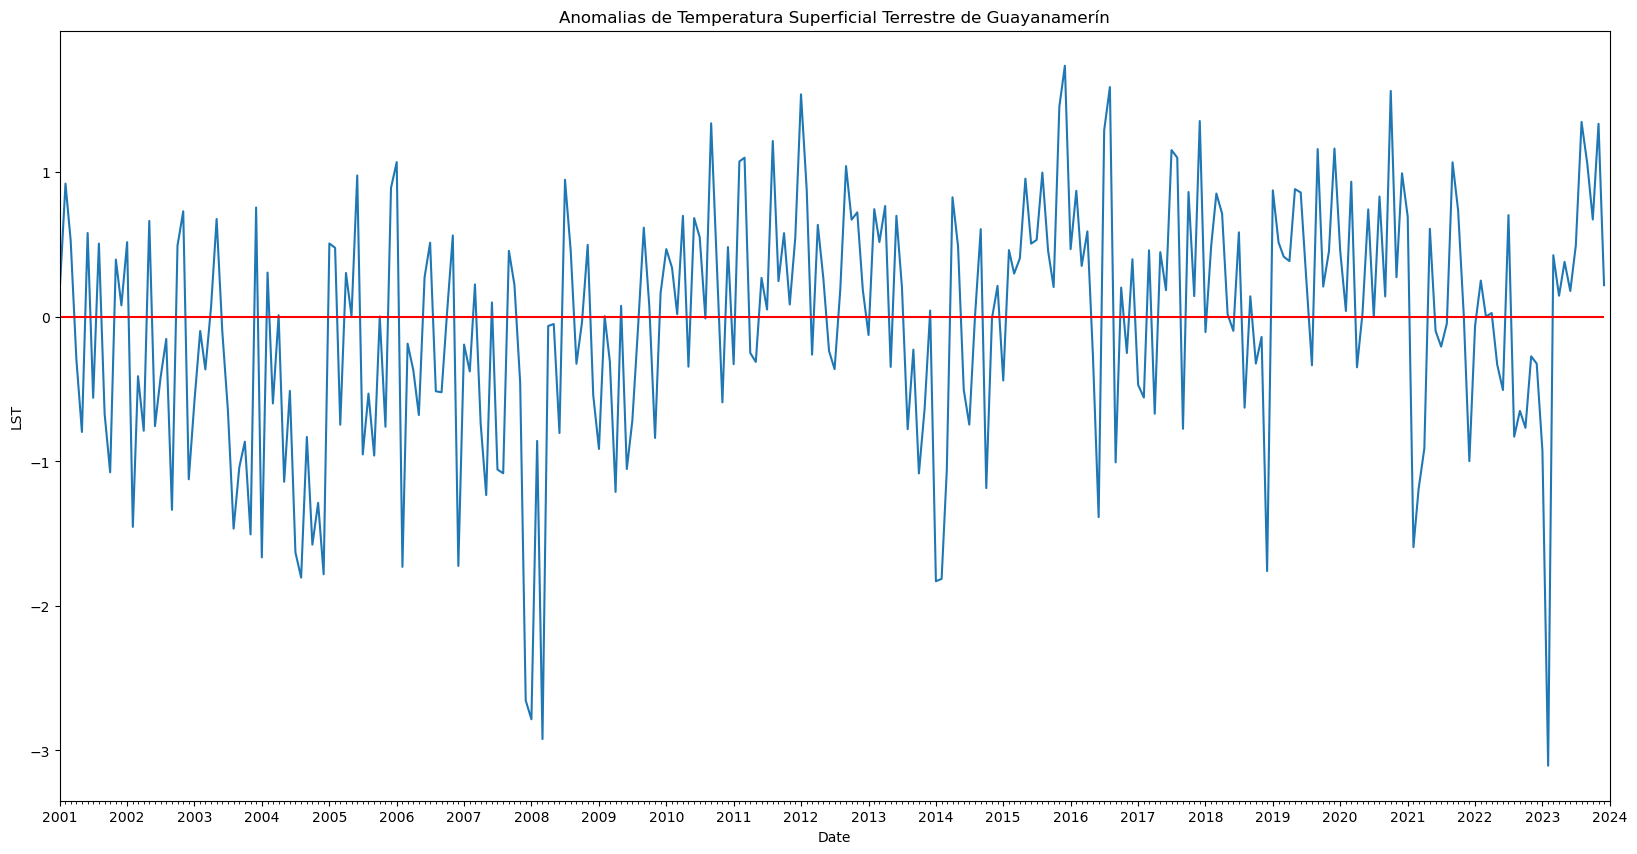

In [72]:
import matplotlib.dates as mdates
import datetime
fig, ax = plt.subplots(figsize=(20,10))
tmp = df[df["MUNICIPIO"]=="Guayaramerín"]
#ax.plot(tmp["Date"], tmp["LST"])
sns.lineplot(data=tmp, x="Date", y="LST")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.hlines(xmin=df.Date.min(), xmax=df.Date.max(), y=0, color="red")
#ax.tick_params(axis='x', which='minor', length=5, width=1)
ax.xaxis.set_tick_params(which='minor', bottom=True)
ax.set_title("Anomalias de Temperatura Superficial Terrestre de Guayanamerín")
ax.set_xlim(datetime.datetime(2001, 1, 1), datetime.datetime(2024, 1, 1))                        


### Reducción anual

In [73]:
anual  = anomalyYear.toBands()
dataAnual = anual.reduceRegions(collection=corte, reducer=ee.Reducer.mean(), scale=1000, crs="EPSG:32719")

In [74]:
dfAnual = gpd.GeoDataFrame.from_features(dataAnual.getInfo())

In [75]:
dfAnual

,geometry,2001_LST_Day_1km,2002_LST_Day_1km,2003_LST_Day_1km,2004_LST_Day_1km,2005_LST_Day_1km,2006_LST_Day_1km,2007_LST_Day_1km,2008_LST_Day_1km,2009_LST_Day_1km,...,2021_LST_Day_1km,2022_LST_Day_1km,2023_LST_Day_1km,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id
0,"POLYGON ((-64.75414 -15.04057, -64.75437 -15.0...",-0.628728,-0.042956,-0.301428,-0.065162,0.299242,-0.135631,-0.752762,0.514476,-0.596159,...,0.049302,-0.080948,0.426853,Loreto,Beni,Loreto,Marbán,682744,080601,39
1,"POLYGON ((-65.49635 -14.37117, -65.49718 -14.3...",-0.174270,0.104228,-0.275193,0.064941,0.121441,-0.018103,-0.676859,0.344845,-0.573325,...,-0.103170,-0.115764,0.441056,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50
2,"POLYGON ((-65.04075 -14.73925, -65.04318 -14.7...",-1.071529,-0.100769,-0.806913,-0.492774,0.105346,0.240085,-0.728374,0.652628,-0.763606,...,0.077021,0.500752,0.553162,San Javier,Beni,San Javier,Cercado,879041,080102,51
3,"POLYGON ((-64.03329 -13.44887, -64.11278 -13.4...",-0.757375,0.002819,-0.832181,-0.789247,0.396198,-0.168459,-0.783227,0.255117,-0.933321,...,0.219481,0.092288,0.317288,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64
4,"POLYGON ((-65.03239 -11.99821, -65.03643 -11.9...",-0.100259,0.231833,-0.416641,-0.632786,0.504664,-0.138500,-0.744490,-0.546182,-0.306555,...,-0.325949,-0.174071,0.541893,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67
5,"POLYGON ((-64.36398 -12.54335, -64.36597 -12.5...",-0.659250,0.044834,-0.596111,-0.700439,0.435589,0.146828,-0.913099,-0.100874,-0.846157,...,-0.019043,-0.049803,0.329884,San Ramón,Beni,San Ramón,Mamoré,799088,080702,68
6,"POLYGON ((-63.76698 -12.44120, -63.76759 -12.4...",-0.205960,-0.010523,-0.235690,-0.719552,0.347355,-0.407157,-0.460887,-0.016066,-0.571580,...,0.007683,-0.286361,0.598304,Magdalena,Beni,Magdalena,Iténez,1410205,080801,82
7,"POLYGON ((-66.26304 -12.00437, -66.26383 -12.0...",-0.367027,0.061046,-0.506004,-0.555972,-0.110176,-0.207943,-1.089032,1.070547,-0.655165,...,-0.028574,-0.785007,0.541430,Santa Rosa,Beni,Santa Rosa,General José Ballivián,949775,080303,137
8,"POLYGON ((-67.35071 -14.38574, -67.35208 -14.3...",-0.195980,-0.224040,-0.692893,-0.340010,-0.280483,-0.302045,-0.713017,0.183336,-0.101309,...,0.509194,-0.143191,0.938738,Rurrenabaque,Beni,Puerto Menor de Rurrenabaque,General José Ballivián,251977,080304,200
9,"POLYGON ((-66.45218 -13.57205, -66.51578 -13.5...",-0.425571,-0.154576,-0.500847,-0.292931,0.070695,0.018860,-0.992171,0.513776,-0.573232,...,-0.178934,-0.119364,0.832650,Santa Ana de Yacuma,Beni,Santa Ana,Yacuma,2130781,080401,202


In [76]:
df = dfAnual.melt(id_vars=dfAnual.columns[-7:], value_vars=dfAnual.columns[1:-7], var_name="year", value_name="LST")

In [77]:
df["year"] = [int(i[:4]) for i in df["year"]]

In [78]:
df

,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,id,year,LST
0,Loreto,Beni,Loreto,Marbán,682744,080601,39,2001,-0.628728
1,San Ignacio,Beni,San Ignacio,Moxos,2511675,080501,50,2001,-0.174270
2,San Javier,Beni,San Javier,Cercado,879041,080102,51,2001,-1.071529
3,Huacaraje,Beni,Huacaraje,Iténez,551368,080803,64,2001,-0.757375
4,San Joaquín,Beni,San Joaquín,Mamoré,867826,080701,67,2001,-0.100259
...,...,...,...,...,...,...,...,...,...
432,Riberalta,Beni,Riberalta,Vaca Diez,1279773,080201,208,2023,0.212843
433,Guayaramerín,Beni,Guayaramerín,Vaca Diez,648861,080202,215,2023,0.356237
434,San Andrés,Beni,San Andrés,Marbán,997060,080602,261,2023,0.040421
435,Baures,Beni,Baures,Iténez,1768512,080802,284,2023,0.723576


<Axes: xlabel='year', ylabel='LST'>

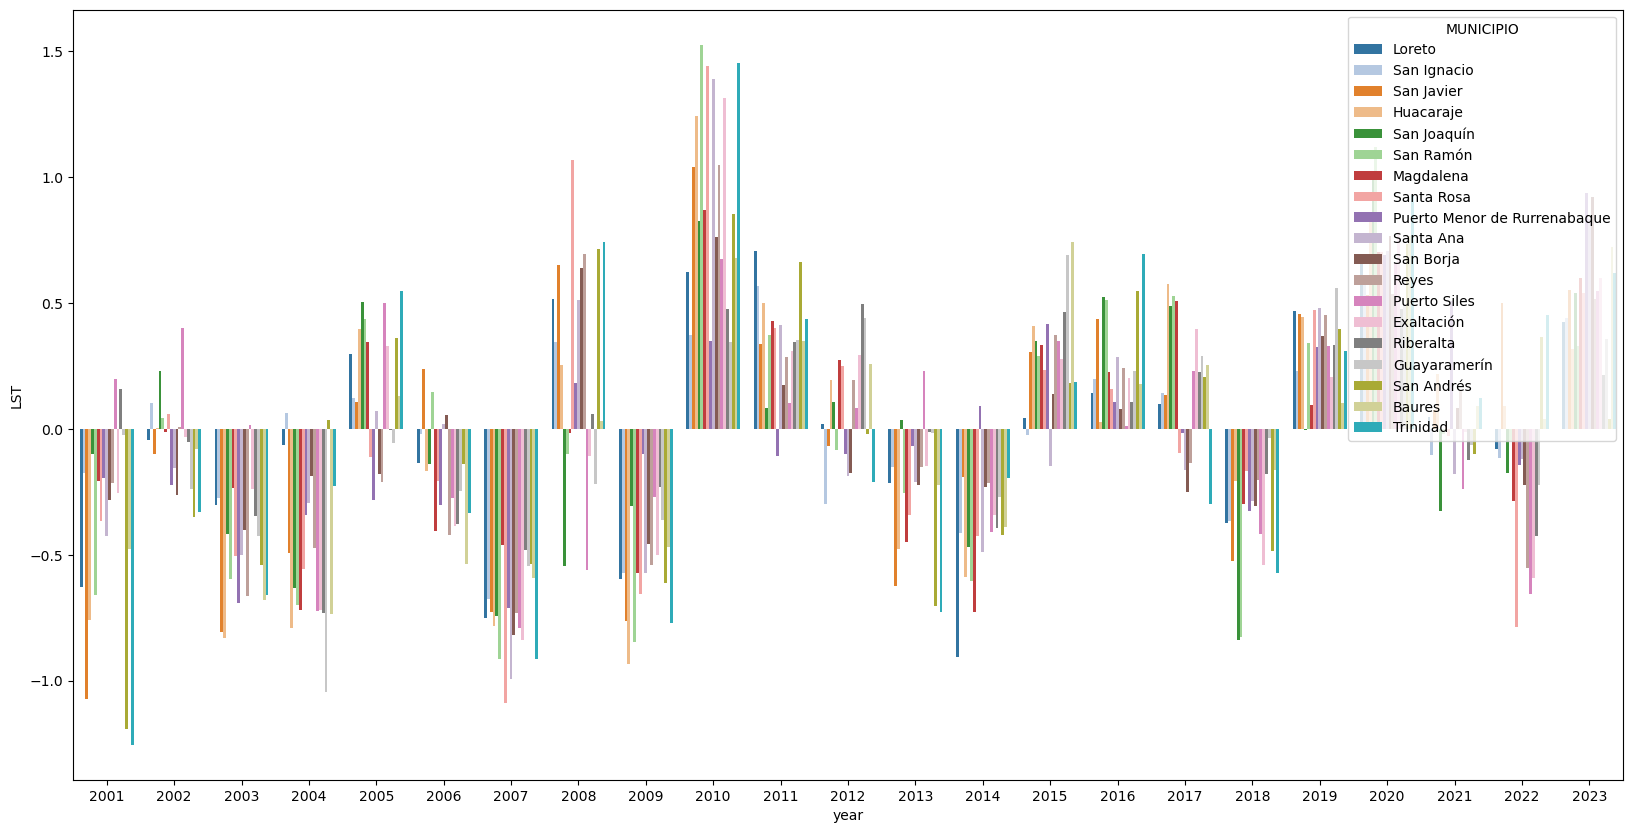

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=df, x="year", y="LST", hue="MUNICIPIO", palette=sns.color_palette("tab20",19))

# Plus 1: En caso que quieran correr modelos más grandes como es el caso de Santa Cruz donde hay limitación de memoría

In [80]:
gdf2 = gdf.loc[gdf["DEPARTAMEN"]=="Santa Cruz"].copy()

In [81]:
gdf2.shape

(56, 8)

In [82]:
rows = int(gdf2.shape[0])
half_size = int(rows/2)
lista = half_size*[1] + half_size*[2]
gdf2["division"] = lista


In [83]:
mes  = anomalyMonth.toBands()
nuevo = []
for div in gdf2["division"].unique():
    tmp = gdf2.loc[gdf2["division"]==div]
    corte = ee.FeatureCollection(json.loads(tmp.to_json()))
    dataMes =  mes.reduceRegions(collection=corte, reducer=ee.Reducer.mean(), scale=1000, crs="EPSG:32719")
    nuevo.append(gpd.GeoDataFrame.from_features(dataMes.getInfo()))

In [84]:
pd.concat(nuevo)

,geometry,2001_01_LST_Day_1km,2001_02_LST_Day_1km,2001_03_LST_Day_1km,2001_04_LST_Day_1km,2001_05_LST_Day_1km,2001_06_LST_Day_1km,2001_07_LST_Day_1km,2001_08_LST_Day_1km,2001_09_LST_Day_1km,...,2023_11_LST_Day_1km,2023_12_LST_Day_1km,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,division,id
0,"POLYGON ((-57.63652 -17.98160, -57.71420 -17.9...",-1.406156,0.421911,-0.938399,-0.083459,-1.641764,1.610025,0.225422,1.023512,-0.443088,...,2.101771,1.224271,Puerto Quijarro,Santa Cruz,Puerto Quijarro,Germán Busch,143876,071402,1,17
1,"POLYGON ((-63.24398 -17.83487, -63.24605 -17.8...",-1.375990,0.605047,-1.513880,0.292574,-0.578560,1.120546,-1.006772,1.118594,-1.443220,...,-0.510575,1.419566,La Guardia,Santa Cruz,La Guardia,Andrés Ibáñez,97792,070104,1,26
2,"POLYGON ((-64.31082 -18.16250, -64.31120 -18.1...",-0.578444,2.367760,-0.280732,-0.528479,-1.116199,-0.454412,0.046154,0.849752,-0.776849,...,0.312948,-0.562700,Moromoro,Santa Cruz,Moromoro,Vallegrande,68050,070803,1,27
3,"POLYGON ((-63.58040 -18.05732, -63.57888 -18.0...",-1.151728,0.906305,-0.950724,0.123015,0.427358,1.490553,0.308608,1.629648,-1.481516,...,-0.213091,1.263073,El Torno,Santa Cruz,El Torno,Andrés Ibáñez,97015,070105,1,28
4,"POLYGON ((-63.97310 -17.85200, -63.97524 -17.8...",-1.118711,0.689628,-1.093321,0.027273,0.388738,0.209303,0.500993,1.041806,-0.817054,...,-0.319109,-0.992912,Samaipata,Santa Cruz,Samaipata,Florida,192626,070901,1,29
5,"POLYGON ((-64.22036 -16.26585, -64.22048 -16.2...",-1.817672,-0.624614,-0.777541,-0.590395,-1.362653,1.058423,-3.055329,0.033575,-2.095183,...,0.807333,0.617228,San Juan,Santa Cruz,San Juan,Ichilo,158651,070404,1,33
6,"POLYGON ((-64.78659 -17.93331, -64.81061 -17.9...",-1.569087,0.883921,-0.774275,-1.302635,-1.287421,0.849691,0.974773,1.218964,0.476123,...,0.610040,0.469160,Saipina,Santa Cruz,Saipina,Manuel María Caballero,44997,071302,1,46
7,"POLYGON ((-63.42969 -17.56038, -63.43232 -17.5...",-0.746048,0.105997,-0.761800,0.659481,-0.552315,1.833198,-1.851399,0.277377,-2.764316,...,0.602895,0.606825,Porongo (Ayacucho),Santa Cruz,Porongo,Andrés Ibáñez,94005,070103,1,48
8,"POLYGON ((-62.76504 -17.57887, -62.76378 -17.5...",-1.693718,-0.229036,-1.720037,0.597977,-1.649089,1.276788,-2.344708,0.768112,-0.530927,...,1.776979,2.277529,Santa Cruz de la Sierra,Santa Cruz,Santa Cruz de la Sierra,Andrés Ibáñez,129976,070101,1,49
9,"POLYGON ((-64.01103 -16.04173, -64.01185 -16.0...",-2.021339,-0.316278,-1.727120,-1.781047,-2.398982,0.554280,-4.311254,-1.743834,-3.193834,...,1.024647,1.420366,San Pedro,Santa Cruz,San Pedro,Obispo Santistéban,307621,071005,1,52


# Plus 2: En caso de que quieras meses especificos 

In [92]:
import itertools

años = list(range(startYear, endYear+1))
meses = list(range(1, 13, 2))
lista  = list(itertools.product(años, meses))
listaMeses = [ee.Date.fromYMD(año, mes, 1) for año, mes in lista]
numberMonths = ee.List(listaMeses)

In [94]:
lista


[(2001, 1),
 (2001, 3),
 (2001, 5),
 (2001, 7),
 (2001, 9),
 (2001, 11),
 (2002, 1),
 (2002, 3),
 (2002, 5),
 (2002, 7),
 (2002, 9),
 (2002, 11),
 (2003, 1),
 (2003, 3),
 (2003, 5),
 (2003, 7),
 (2003, 9),
 (2003, 11),
 (2004, 1),
 (2004, 3),
 (2004, 5),
 (2004, 7),
 (2004, 9),
 (2004, 11),
 (2005, 1),
 (2005, 3),
 (2005, 5),
 (2005, 7),
 (2005, 9),
 (2005, 11),
 (2006, 1),
 (2006, 3),
 (2006, 5),
 (2006, 7),
 (2006, 9),
 (2006, 11),
 (2007, 1),
 (2007, 3),
 (2007, 5),
 (2007, 7),
 (2007, 9),
 (2007, 11),
 (2008, 1),
 (2008, 3),
 (2008, 5),
 (2008, 7),
 (2008, 9),
 (2008, 11),
 (2009, 1),
 (2009, 3),
 (2009, 5),
 (2009, 7),
 (2009, 9),
 (2009, 11),
 (2010, 1),
 (2010, 3),
 (2010, 5),
 (2010, 7),
 (2010, 9),
 (2010, 11),
 (2011, 1),
 (2011, 3),
 (2011, 5),
 (2011, 7),
 (2011, 9),
 (2011, 11),
 (2012, 1),
 (2012, 3),
 (2012, 5),
 (2012, 7),
 (2012, 9),
 (2012, 11),
 (2013, 1),
 (2013, 3),
 (2013, 5),
 (2013, 7),
 (2013, 9),
 (2013, 11),
 (2014, 1),
 (2014, 3),
 (2014, 5),
 (2014, 7),
 (2

In [88]:
def monthlyCalc(start):
  start = ee.Date(start)
  end = start.advance(1, "month")
  monthy = modLSTday.filterDate(start, end)
  return monthy.mean()\
              .set('system:time_start', start.millis())\
              .set('system:time_end', end.millis())\
              .set('system:index', start.format('yyyy_MM'))
monthly2 = ee.ImageCollection(numberMonths.map(monthlyCalc))

In [89]:
anomalyMonth2 = monthly2.map(anomalyM)

In [90]:
mes  = anomalyMonth2.toBands()
dataMes =  mes.reduceRegions(collection=corte, reducer=ee.Reducer.mean(), scale=1000, crs="EPSG:32719")

In [91]:
gpd.GeoDataFrame.from_features(dataMes.getInfo())

,geometry,2001_01_LST_Day_1km,2001_03_LST_Day_1km,2001_05_LST_Day_1km,2001_07_LST_Day_1km,2001_09_LST_Day_1km,2001_11_LST_Day_1km,2002_01_LST_Day_1km,2002_03_LST_Day_1km,2002_05_LST_Day_1km,...,2023_09_LST_Day_1km,2023_11_LST_Day_1km,CAPITAL,DEPARTAMEN,MUNICIPIO,PROVINCIA,areaha,c_ut,division,id
0,"POLYGON ((-61.96629 -17.03809, -61.96749 -17.0...",-0.182525,-2.296383,-3.266425,-1.267226,-0.325377,-6.528728,1.875924,-2.352709,1.926384,...,-0.277578,2.193932,Cuatro Cañadas,Santa Cruz,Cuatro Cañadas,Ñuflo De Chávez,445899,071106,2,251
1,"POLYGON ((-62.49320 -16.47498, -62.49345 -16.4...",-1.690775,-0.847652,-2.907053,-1.833306,-1.596176,-4.544920,-0.275358,0.266492,1.086237,...,0.474965,3.896506,San Ramón,Santa Cruz,San Ramón,Ñuflo De Chávez,50406,071105,2,252
2,"POLYGON ((-62.58475 -15.84777, -62.58529 -15.8...",-2.271825,-1.190941,-2.255284,-1.848164,0.091139,-3.274622,-0.568205,0.127359,1.368571,...,0.718863,3.497115,San Javier,Santa Cruz,San Javier,Ñuflo De Chávez,227317,071102,2,253
3,"POLYGON ((-61.29029 -16.21838, -61.29060 -16.2...",-0.246007,-0.136356,-2.362363,-0.460933,0.349429,-3.297525,0.238094,1.218295,1.673590,...,0.543634,4.545742,San Miguel,Santa Cruz,San Miguel,Velasco,961684,070302,2,254
4,"POLYGON ((-63.24694 -17.25512, -63.29004 -17.2...",-1.473533,-1.097983,-2.265415,-2.802464,-1.362790,-3.087233,1.177059,-2.333728,0.368155,...,0.219211,2.715753,Montero,Santa Cruz,Montero,Obispo Santistéban,24683,071001,2,259
5,"POLYGON ((-63.52808 -14.29283, -63.52871 -14.2...",-1.839442,-1.040597,-1.980965,-1.480804,-2.112770,-2.407415,-0.069939,-0.503380,-0.015503,...,0.626032,2.565320,Ascención de Guarayos,Santa Cruz,Ascención de Guarayos,Guarayos,903838,071501,2,260
6,"POLYGON ((-62.99244 -17.07929, -62.99300 -17.0...",-1.611435,-1.772281,-2.531975,-1.990265,-0.708222,-4.782232,0.608146,-1.976097,1.665320,...,-0.257835,1.780329,Okinawa Uno,Santa Cruz,Okinawa Uno,Warnes,103365,070202,2,264
7,"POLYGON ((-63.03269 -17.04194, -63.03328 -17.0...",-1.425416,-1.241465,-1.213993,-2.807966,-1.022895,-3.518001,2.210484,-2.151280,0.872623,...,-0.036611,2.360765,Warnes,Santa Cruz,Warnes,Warnes,134265,070201,2,265
8,"POLYGON ((-63.04051 -17.00863, -63.04087 -17.0...",-1.659210,-1.787903,-0.918781,-3.215854,-1.838350,-3.339719,1.715597,-1.012131,1.447685,...,-0.313068,3.020222,General Saavedra,Santa Cruz,General Saavedra,Obispo Santistéban,53494,071002,2,266
9,"POLYGON ((-61.54988 -17.27060, -61.55022 -17.2...",-1.125435,-1.338219,-2.804912,-1.174228,-0.707591,-6.471944,0.893865,-1.409563,1.376384,...,0.524891,3.398715,Pailón,Santa Cruz,Pailón,Chiquitos,1376915,070502,2,267
